# Imports

In [1]:
import os
import pickle
import time, datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision
from tqdm import tqdm
import tensorflow as tf

# Save Methods

In [2]:
# Plot training loss
def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    """Loss tracker
    
    Plot the losses of the networks independently to see the trend
    
    Arguments:
        hist {[dict]} -- Tracking variables
    
    Keyword Arguments:
        show {bool} -- If to display the figure (default: {False})
        save {bool} -- If to store the figure (default: {False})
        path {str} -- path to store the figure (default: {'Train_hist.png'})
    """
    x = range(len(hist['VGG_losses']))

    y1 = hist['VGG_losses']
    y2 = hist['ResNet_losses']
    y3 = hist['GGL_Net_losses']

    plt.plot(x, y1, label='VGG_loss')
    plt.plot(x, y2, label='ResNet_loss')
    plt.plot(x, y3, label='GoogLeNet_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# Plot validation accuracy
def show_accuracy_plot(hist, show=False, save=False, path='Accuracy_hist.png'):
    """Loss tracker
    
    Plot the losses of the networks independently to see the trend
    
    Arguments:
        hist {[dict]} -- Tracking variables
    
    Keyword Arguments:
        show {bool} -- If to display the figure (default: {False})
        save {bool} -- If to store the figure (default: {False})
        path {str} -- path to store the figure (default: {'Train_hist.png'})
    """
    x = range(len(hist['VGG_accuracy']))

    y1 = hist['VGG_accuracy']
    y2 = hist['ResNet_accuracy']
    y3 = hist['GGL_Net_accuracy']

    plt.plot(x, y1, label='VGG_Accuracy')
    plt.plot(x, y2, label='ResNet_Accuracy')
    plt.plot(x, y3, label='GoogLeNet_Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend(loc=4)
    plt.grid(True)
    #plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

# Initial Set-up

In [3]:
# initialise the device for training, if gpu is available, device = 'cuda', else: device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

save_dir = './Results/'
model_dir = './Models/'
# create folder if not exist
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

cuda


# Model loading
Create Models and Model Training Methods

### VGG Model methods

In [4]:
def LoadVGG(device):
    VGG_net = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=False)
    VGG_net = VGG_net.to(device)

    VGG_optimizer = optim.SGD(VGG_net.parameters(), lr=0.01, momentum=0.7, weight_decay=0.0005)
    VGG_scheduler = optim.lr_scheduler.ReduceLROnPlateau(VGG_optimizer, mode='max', patience=5, verbose=True)

    return VGG_net, VGG_optimizer, VGG_scheduler

def TrainVGG(VGG_net, optimizer, scheduler, criterion, epochs, train_loader, validation_loader):
    print('\nTraining VGG')
    train_hist['per_epoch_ptimes'].clear()
    start_time = time.time()
    now = datetime.datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Training starting ',str(dt_string))
    for epoch in range(epochs):
        Train_Loss = []
        epoch_start_time = time.time()
        now = datetime.datetime.now()
        print('Epoch %d starting at: %02d:%02d:%02d'%(epoch+1, now.hour, now.minute, now.second))
        VGG_net.train()
        # Training
        for (train_images, train_labels) in tqdm(train_loader):
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_outputs = VGG_net(train_images)
            train_loss = criterion(train_outputs, train_labels)
            train_loss.backward()
            optimizer.step()

            Train_Loss.append(train_loss.item())
        
        VGG_net.eval()
        Val_Loss = []
        total = 0
        correct = 0
        # Validation
        for (val_images, val_labels) in tqdm(validation_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # calculate outputs by running images through the network
            val_outputs = VGG_net(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            Val_Loss.append(val_loss.item())

            # apply softmax function to get probabilities
            s = nn.Softmax(dim=1)
            probabilities = s(val_outputs)
            # class with highest probability is the predicted class
            _, predicted = torch.max(probabilities.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

        # validation accuracy
        epoch_accuracy = 100 * correct / total

        # Learning Rate Adaptation step
        # changes LR on flat plateau
        scheduler.step(epoch_accuracy)

        epoch_loss = np.mean(Train_Loss)  # mean loss for the epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("\nEpoch %d of %d, %.2f s, with average training loss: %.8f, and validation loss: %.8f, validation accuracy: %.2f" 
              % (epoch + 1, epochs, per_epoch_ptime, epoch_loss, np.mean(Val_Loss), epoch_accuracy))

        # record the loss for every epoch
        train_hist['VGG_losses'].append(epoch_loss)
        train_hist['VGG_accuracy'].append(epoch_accuracy)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    now = datetime.datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Finished Training ',str(dt_string))

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), epochs, total_ptime))

### ResNet Model methods

In [5]:
def LoadResNet(device):
    ResNet_net = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=False)
    ResNet_net = ResNet_net.to(device)

    ResNet_optimizer = optim.SGD(ResNet_net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    ResNet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(ResNet_optimizer, mode='max', patience=5, verbose=True)

    return ResNet_net, ResNet_optimizer, ResNet_scheduler

def TrainResNet(ResNet_net, optimizer, scheduler, criterion, epochs, train_loader, validation_loader):
    print('\nTraining ResNet')
    train_hist['per_epoch_ptimes'].clear()
    start_time = time.time()
    now = datetime.datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Training starting ',dt_string)
    for epoch in range(epochs):
        Train_Loss = []
        epoch_start_time = time.time()
        now = datetime.datetime.now()
        print('Epoch %d starting at: %02d:%02d:%02d'%(epoch+1, now.hour, now.minute, now.second))
        ResNet_net.train()
        # Training
        for (train_images, train_labels) in tqdm(train_loader):
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_outputs = ResNet_net(train_images)
            train_loss = criterion(train_outputs, train_labels)
            train_loss.backward()
            optimizer.step()

            Train_Loss.append(train_loss.item())
        
        ResNet_net.eval()
        Val_Loss = []
        total = 0
        correct = 0
        # Validation
        for (val_images, val_labels) in tqdm(validation_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # calculate outputs by running images through the network
            val_outputs = ResNet_net(val_images)
            val_loss = criterion(val_outputs, val_labels)
            
            Val_Loss.append(val_loss.item())

            # apply softmax function to get probabilities
            s = nn.Softmax(dim=1)
            probabilities = s(val_outputs)
            # class with highest probability is the predicted class
            _, predicted = torch.max(probabilities.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

        # validation accuracy
        epoch_accuracy = 100 * correct / total

        # Learning Rate Adaptation step
        # changes LR on flat plateau
        scheduler.step(epoch_accuracy)

        epoch_loss = np.mean(Train_Loss)  # mean generator loss for the epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("\nEpoch %d of %d, %.2f s, with average training loss: %.8f, and validation loss: %.8f, validation accuracy: %.2f" 
              % (epoch + 1, epochs, per_epoch_ptime, epoch_loss, np.mean(Val_Loss), epoch_accuracy))

        # record the loss for every epoch
        train_hist['ResNet_losses'].append(epoch_loss)
        train_hist['ResNet_accuracy'].append(epoch_accuracy)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    now = datetime.datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Finished Training ',str(dt_string))

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), epochs, total_ptime))

### GoogLeNet Model Methods

In [6]:
def LoadGLNet(device):
    GLNet_net = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=False)
    GLNet_net = GLNet_net.to(device)

    GLNet_optimizer = optim.SGD(GLNet_net.parameters(), lr=0.01, momentum=0.9)
    GLNet_scheduler = optim.lr_scheduler.StepLR(GLNet_optimizer, step_size=8, gamma=0.96, verbose=True)

    return GLNet_net, GLNet_optimizer, GLNet_scheduler

def TrainGLNet(GLNet_net, optimizer, scheduler, criterion, epochs, train_loader):
    print('\nTraining GoogLeNet')
    train_hist['per_epoch_ptimes'].clear()
    start_time = time.time()
    now = datetime.datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Training starting ',dt_string)
    for epoch in range(epochs):
        # Record epoch start time
        epoch_start_time = time.time()
        now = datetime.datetime.now()
        print('Epoch %d starting at: %02d:%02d:%02d'%(epoch+1, now.hour, now.minute, now.second))

        GLNet_net.train()
        Train_Loss = []
        # Training
        for (train_images, train_labels) in tqdm(train_loader):
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_outputs = GLNet_net(train_images)
            train_outputs = train_outputs.logits
            train_loss = criterion(train_outputs, train_labels)
            train_loss.backward()
            optimizer.step()

            Train_Loss.append(train_loss.item())

        GLNet_net.eval()
        Val_Loss = []
        total = 0
        correct = 0
        # Validation
        for (val_images, val_labels) in tqdm(validation_loader):
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # calculate outputs by running images through the network
            val_outputs = GLNet_net(val_images)

            # apply softmax function to get probabilities
            s = nn.Softmax(dim=1)
            probabilities = s(val_outputs)
            # class with highest probability is the predicted class
            _, predicted = torch.max(probabilities.data, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

        # validation accuracy
        epoch_accuracy = 100 * correct / total

        # Learning Rate Adaptation step
        # changes LR every 8 epochs
        scheduler.step()

        epoch_loss = np.mean(Train_Loss)  # mean generator loss for the epoch
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print("\nEpoch %d of %d, %.2f s, with average training loss: %.8f, and validation loss: %.8f, validation accuracy: %.2f" 
              % (epoch + 1, epochs, per_epoch_ptime, epoch_loss, np.mean(Val_Loss), epoch_accuracy))

        # record the loss for every epoch
        train_hist['GGL_Net_losses'].append(epoch_loss)
        train_hist['GGL_Net_accuracy'].append(epoch_accuracy)
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

    now = datetime.datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    print('Finished Training ',str(dt_string))

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print('Avg per epoch ptime: %.2f, total %d epochs ptime: %.2f' % (np.mean(train_hist['per_epoch_ptimes']), epochs, total_ptime))

# Model Training

## Train on MNIST

### Data Loading and Processing

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_data/MNIST/raw




Extracting ./MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


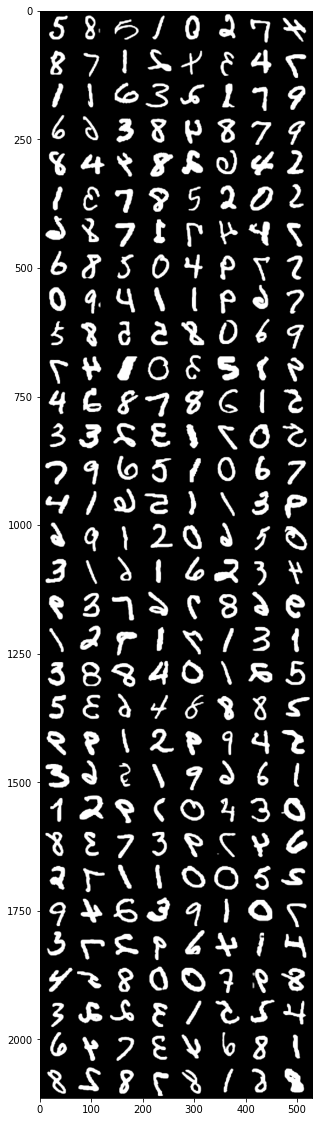

In [7]:
data_dir = './MNIST_data/'

# training parameters
batch_size = 256
epochs = 100

tv_data = datasets.MNIST(root=data_dir, train=True, transform=transforms.Compose([
        transforms.ToTensor()
    ]), download=True)
loader = DataLoader(tv_data, batch_size=len(tv_data))
data = next(iter(loader))
mean = data[0].mean()
std = data[0].std()

# construct the datasets and data loaders
transform = transforms.Compose([transforms.Grayscale(3),
                                transforms.Resize(64),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((mean, mean, mean), (std, std, std))])
tv_data = datasets.MNIST(root=data_dir, train=True, transform=transform, download=True)
train_data, validation_data = torch.utils.data.random_split(tv_data, [50000, 10000])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_data, batch_size=batch_size, shuffle=True)

def imshow(img):
    plt.figure(figsize=(20,20))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Training Setup

In [8]:
# tracking variables
train_hist = {}
train_hist['VGG_losses'] = []
train_hist['VGG_accuracy'] = []
train_hist['ResNet_losses'] = []
train_hist['ResNet_accuracy'] = []
train_hist['GGL_Net_losses'] = []
train_hist['GGL_Net_accuracy'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# Loss function
criterion = nn.CrossEntropyLoss().to(device)

# Classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### VGG Training

In [9]:
# Load and trian VGG
net, optimizer, scheduler = LoadVGG(device)
TrainVGG(net, optimizer, scheduler, criterion, epochs, train_loader, validation_loader)
torch.save(net.state_dict(), model_dir + '/VGG_MNIST_model.pth')
del net
del optimizer
del scheduler

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
  0%|          | 0/196 [00:00<?, ?it/s]


Training VGG
Training starting  11/05/2021 17:28:43
Epoch 1 starting at: 17:28:43


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 1 of 100, 58.06 s, with average training loss: 2.89111290, and validation loss: 0.78296236, validation accuracy: 74.76
Epoch 2 starting at: 17:29:41


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 2 of 100, 57.79 s, with average training loss: 0.36325642, and validation loss: 0.18946756, validation accuracy: 93.89
Epoch 3 starting at: 17:30:39


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 3 of 100, 57.56 s, with average training loss: 0.15467799, and validation loss: 0.12381925, validation accuracy: 96.28
Epoch 4 starting at: 17:31:36


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 4 of 100, 57.66 s, with average training loss: 0.10781612, and validation loss: 0.14808131, validation accuracy: 95.44
Epoch 5 starting at: 17:32:34


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 5 of 100, 57.69 s, with average training loss: 0.08515193, and validation loss: 0.09060719, validation accuracy: 97.04
Epoch 6 starting at: 17:33:32


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 6 of 100, 57.84 s, with average training loss: 0.06827706, and validation loss: 0.07172707, validation accuracy: 97.89
Epoch 7 starting at: 17:34:30


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 7 of 100, 57.87 s, with average training loss: 0.05726791, and validation loss: 0.08335207, validation accuracy: 97.48
Epoch 8 starting at: 17:35:27


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 8 of 100, 57.85 s, with average training loss: 0.04871428, and validation loss: 0.05669854, validation accuracy: 98.36
Epoch 9 starting at: 17:36:25


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 9 of 100, 57.77 s, with average training loss: 0.04178330, and validation loss: 0.06277497, validation accuracy: 98.16
Epoch 10 starting at: 17:37:23


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 10 of 100, 57.78 s, with average training loss: 0.03929101, and validation loss: 0.07188922, validation accuracy: 98.02
Epoch 11 starting at: 17:38:21


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 11 of 100, 57.90 s, with average training loss: 0.03446301, and validation loss: 0.06385594, validation accuracy: 98.25
Epoch 12 starting at: 17:39:19


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 12 of 100, 58.03 s, with average training loss: 0.02742103, and validation loss: 0.09673293, validation accuracy: 97.76
Epoch 13 starting at: 17:40:17


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 13 of 100, 57.75 s, with average training loss: 0.02706189, and validation loss: 0.06011772, validation accuracy: 98.26
Epoch 14 starting at: 17:41:15


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 14 of 100, 57.75 s, with average training loss: 0.02448892, and validation loss: 0.04634999, validation accuracy: 98.80
Epoch 15 starting at: 17:42:12


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 15 of 100, 57.69 s, with average training loss: 0.02132241, and validation loss: 0.05633526, validation accuracy: 98.50
Epoch 16 starting at: 17:43:10


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 16 of 100, 57.85 s, with average training loss: 0.02140372, and validation loss: 0.04998369, validation accuracy: 98.49
Epoch 17 starting at: 17:44:08


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 17 of 100, 57.97 s, with average training loss: 0.01612535, and validation loss: 0.05392812, validation accuracy: 98.63
Epoch 18 starting at: 17:45:06


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 18 of 100, 57.78 s, with average training loss: 0.01616519, and validation loss: 0.04670524, validation accuracy: 98.79
Epoch 19 starting at: 17:46:04


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 19 of 100, 57.92 s, with average training loss: 0.01384799, and validation loss: 0.05397854, validation accuracy: 98.52
Epoch 20 starting at: 17:47:02


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch    20: reducing learning rate of group 0 to 1.0000e-03.

Epoch 20 of 100, 57.61 s, with average training loss: 0.01449348, and validation loss: 0.06654882, validation accuracy: 98.23
Epoch 21 starting at: 17:47:59


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 21 of 100, 58.11 s, with average training loss: 0.00702809, and validation loss: 0.04448745, validation accuracy: 98.88
Epoch 22 starting at: 17:48:57


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 22 of 100, 58.14 s, with average training loss: 0.00420818, and validation loss: 0.04972678, validation accuracy: 98.84
Epoch 23 starting at: 17:49:55


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 23 of 100, 57.54 s, with average training loss: 0.00316183, and validation loss: 0.04631790, validation accuracy: 98.97
Epoch 24 starting at: 17:50:53


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 24 of 100, 57.94 s, with average training loss: 0.00303326, and validation loss: 0.04424373, validation accuracy: 99.09
Epoch 25 starting at: 17:51:51


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 25 of 100, 57.76 s, with average training loss: 0.00246060, and validation loss: 0.04457904, validation accuracy: 99.02
Epoch 26 starting at: 17:52:49


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 26 of 100, 57.72 s, with average training loss: 0.00234894, and validation loss: 0.04822909, validation accuracy: 99.03
Epoch 27 starting at: 17:53:46


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 27 of 100, 57.81 s, with average training loss: 0.00210077, and validation loss: 0.04806431, validation accuracy: 98.97
Epoch 28 starting at: 17:54:44


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 28 of 100, 57.96 s, with average training loss: 0.00202745, and validation loss: 0.04883963, validation accuracy: 98.97
Epoch 29 starting at: 17:55:42


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 29 of 100, 57.95 s, with average training loss: 0.00144026, and validation loss: 0.04780394, validation accuracy: 99.05
Epoch 30 starting at: 17:56:40


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch    30: reducing learning rate of group 0 to 1.0000e-04.

Epoch 30 of 100, 57.74 s, with average training loss: 0.00126218, and validation loss: 0.04973347, validation accuracy: 98.99
Epoch 31 starting at: 17:57:38


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 31 of 100, 57.68 s, with average training loss: 0.00121463, and validation loss: 0.05205583, validation accuracy: 98.96
Epoch 32 starting at: 17:58:35


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 32 of 100, 57.87 s, with average training loss: 0.00116292, and validation loss: 0.04675572, validation accuracy: 99.07
Epoch 33 starting at: 17:59:33


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 33 of 100, 58.84 s, with average training loss: 0.00133571, and validation loss: 0.04910563, validation accuracy: 99.00
Epoch 34 starting at: 18:00:32


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 34 of 100, 58.03 s, with average training loss: 0.00104180, and validation loss: 0.04997877, validation accuracy: 98.99
Epoch 35 starting at: 18:01:30


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 35 of 100, 58.19 s, with average training loss: 0.00105557, and validation loss: 0.05230391, validation accuracy: 99.01
Epoch 36 starting at: 18:02:28


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch    36: reducing learning rate of group 0 to 1.0000e-05.

Epoch 36 of 100, 58.07 s, with average training loss: 0.00128898, and validation loss: 0.06022039, validation accuracy: 98.98
Epoch 37 starting at: 18:03:26


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 37 of 100, 57.85 s, with average training loss: 0.00109616, and validation loss: 0.05014368, validation accuracy: 99.02
Epoch 38 starting at: 18:04:24


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 38 of 100, 57.97 s, with average training loss: 0.00120406, and validation loss: 0.04877087, validation accuracy: 99.03
Epoch 39 starting at: 18:05:22


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 39 of 100, 57.65 s, with average training loss: 0.00121112, and validation loss: 0.04832428, validation accuracy: 99.04
Epoch 40 starting at: 18:06:20


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 40 of 100, 57.64 s, with average training loss: 0.00112467, and validation loss: 0.04860422, validation accuracy: 99.06
Epoch 41 starting at: 18:07:18


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 41 of 100, 57.72 s, with average training loss: 0.00093334, and validation loss: 0.05242271, validation accuracy: 99.00
Epoch 42 starting at: 18:08:15


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch    42: reducing learning rate of group 0 to 1.0000e-06.

Epoch 42 of 100, 57.89 s, with average training loss: 0.00108737, and validation loss: 0.05347442, validation accuracy: 98.96
Epoch 43 starting at: 18:09:13


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 43 of 100, 58.89 s, with average training loss: 0.00103887, and validation loss: 0.04844093, validation accuracy: 99.02
Epoch 44 starting at: 18:10:12


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 44 of 100, 58.16 s, with average training loss: 0.00092475, and validation loss: 0.05199567, validation accuracy: 98.97
Epoch 45 starting at: 18:11:10


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 45 of 100, 57.70 s, with average training loss: 0.00106734, and validation loss: 0.05001851, validation accuracy: 98.99
Epoch 46 starting at: 18:12:08


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 46 of 100, 57.57 s, with average training loss: 0.00116894, and validation loss: 0.04729751, validation accuracy: 99.06
Epoch 47 starting at: 18:13:06


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 47 of 100, 57.31 s, with average training loss: 0.00109910, and validation loss: 0.05066338, validation accuracy: 98.92
Epoch 48 starting at: 18:14:03


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch    48: reducing learning rate of group 0 to 1.0000e-07.

Epoch 48 of 100, 57.41 s, with average training loss: 0.00099367, and validation loss: 0.05190598, validation accuracy: 98.99
Epoch 49 starting at: 18:15:00


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 49 of 100, 57.82 s, with average training loss: 0.00098948, and validation loss: 0.04933094, validation accuracy: 98.95
Epoch 50 starting at: 18:15:58


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 50 of 100, 57.67 s, with average training loss: 0.00094832, and validation loss: 0.04850536, validation accuracy: 99.02
Epoch 51 starting at: 18:16:56


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 51 of 100, 57.82 s, with average training loss: 0.00113621, and validation loss: 0.04556372, validation accuracy: 99.03
Epoch 52 starting at: 18:17:54


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 52 of 100, 57.76 s, with average training loss: 0.00114624, and validation loss: 0.05041879, validation accuracy: 98.92
Epoch 53 starting at: 18:18:51


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 53 of 100, 57.32 s, with average training loss: 0.00116484, and validation loss: 0.04837873, validation accuracy: 99.00
Epoch 54 starting at: 18:19:49


  0%|          | 0/196 [00:00<?, ?it/s]

Epoch    54: reducing learning rate of group 0 to 1.0000e-08.

Epoch 54 of 100, 56.99 s, with average training loss: 0.00102145, and validation loss: 0.05326594, validation accuracy: 99.09
Epoch 55 starting at: 18:20:46


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 55 of 100, 58.26 s, with average training loss: 0.00102779, and validation loss: 0.04771231, validation accuracy: 99.04
Epoch 56 starting at: 18:21:44


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 56 of 100, 57.88 s, with average training loss: 0.00108025, and validation loss: 0.04792724, validation accuracy: 99.05
Epoch 57 starting at: 18:22:42


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 57 of 100, 58.36 s, with average training loss: 0.00114887, and validation loss: 0.05072499, validation accuracy: 99.00
Epoch 58 starting at: 18:23:40


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 58 of 100, 58.23 s, with average training loss: 0.00110220, and validation loss: 0.05140841, validation accuracy: 98.96
Epoch 59 starting at: 18:24:38


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 59 of 100, 58.36 s, with average training loss: 0.00126055, and validation loss: 0.04791416, validation accuracy: 98.96
Epoch 60 starting at: 18:25:37


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 60 of 100, 57.96 s, with average training loss: 0.00122550, and validation loss: 0.04925444, validation accuracy: 99.03
Epoch 61 starting at: 18:26:35


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 61 of 100, 57.68 s, with average training loss: 0.00108453, and validation loss: 0.04797934, validation accuracy: 99.01
Epoch 62 starting at: 18:27:32


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 62 of 100, 57.58 s, with average training loss: 0.00096521, and validation loss: 0.05172480, validation accuracy: 98.96
Epoch 63 starting at: 18:28:30


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 63 of 100, 57.88 s, with average training loss: 0.00120565, and validation loss: 0.04789153, validation accuracy: 99.07
Epoch 64 starting at: 18:29:28


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 64 of 100, 58.05 s, with average training loss: 0.00108261, and validation loss: 0.05055192, validation accuracy: 99.01
Epoch 65 starting at: 18:30:26


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 65 of 100, 57.86 s, with average training loss: 0.00101666, and validation loss: 0.05077645, validation accuracy: 98.94
Epoch 66 starting at: 18:31:24


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 66 of 100, 58.18 s, with average training loss: 0.00108233, and validation loss: 0.05052638, validation accuracy: 99.02
Epoch 67 starting at: 18:32:22


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 67 of 100, 57.93 s, with average training loss: 0.00117284, and validation loss: 0.05087671, validation accuracy: 98.92
Epoch 68 starting at: 18:33:20


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 68 of 100, 57.71 s, with average training loss: 0.00101649, and validation loss: 0.05021407, validation accuracy: 98.97
Epoch 69 starting at: 18:34:18


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 69 of 100, 57.61 s, with average training loss: 0.00121000, and validation loss: 0.04875272, validation accuracy: 99.03
Epoch 70 starting at: 18:35:15


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 70 of 100, 57.61 s, with average training loss: 0.00109670, and validation loss: 0.04993046, validation accuracy: 99.05
Epoch 71 starting at: 18:36:13


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 71 of 100, 57.60 s, with average training loss: 0.00110722, and validation loss: 0.06053594, validation accuracy: 98.94
Epoch 72 starting at: 18:37:10


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 72 of 100, 57.41 s, with average training loss: 0.00107431, and validation loss: 0.09241205, validation accuracy: 98.96
Epoch 73 starting at: 18:38:08


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 73 of 100, 57.66 s, with average training loss: 0.00111128, and validation loss: 0.05173204, validation accuracy: 98.97
Epoch 74 starting at: 18:39:05


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 74 of 100, 57.49 s, with average training loss: 0.00110477, and validation loss: 0.04886955, validation accuracy: 99.02
Epoch 75 starting at: 18:40:03


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 75 of 100, 57.79 s, with average training loss: 0.00099182, and validation loss: 0.04938625, validation accuracy: 99.03
Epoch 76 starting at: 18:41:01


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 76 of 100, 58.01 s, with average training loss: 0.00103227, and validation loss: 0.05102701, validation accuracy: 98.96
Epoch 77 starting at: 18:41:59


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 77 of 100, 57.87 s, with average training loss: 0.00109316, and validation loss: 0.05160930, validation accuracy: 99.01
Epoch 78 starting at: 18:42:57


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 78 of 100, 57.54 s, with average training loss: 0.00094524, and validation loss: 0.04962919, validation accuracy: 98.99
Epoch 79 starting at: 18:43:54


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 79 of 100, 57.46 s, with average training loss: 0.00112544, and validation loss: 0.05936148, validation accuracy: 99.04
Epoch 80 starting at: 18:44:52


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 80 of 100, 57.80 s, with average training loss: 0.00108703, and validation loss: 0.05144401, validation accuracy: 98.97
Epoch 81 starting at: 18:45:49


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 81 of 100, 58.51 s, with average training loss: 0.00085436, and validation loss: 0.05432102, validation accuracy: 98.96
Epoch 82 starting at: 18:46:48


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 82 of 100, 58.46 s, with average training loss: 0.00107939, and validation loss: 0.04840119, validation accuracy: 98.97
Epoch 83 starting at: 18:47:46


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 83 of 100, 58.24 s, with average training loss: 0.00127338, and validation loss: 0.05429647, validation accuracy: 98.98
Epoch 84 starting at: 18:48:45


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 84 of 100, 58.08 s, with average training loss: 0.00110255, and validation loss: 0.06266210, validation accuracy: 99.04
Epoch 85 starting at: 18:49:43


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 85 of 100, 58.08 s, with average training loss: 0.00119591, and validation loss: 0.04903635, validation accuracy: 98.97
Epoch 86 starting at: 18:50:41


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 86 of 100, 58.42 s, with average training loss: 0.00113157, and validation loss: 0.04866090, validation accuracy: 99.02
Epoch 87 starting at: 18:51:39


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 87 of 100, 58.72 s, with average training loss: 0.00099559, and validation loss: 0.04786909, validation accuracy: 99.04
Epoch 88 starting at: 18:52:38


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 88 of 100, 58.33 s, with average training loss: 0.00120719, and validation loss: 0.05077140, validation accuracy: 99.00
Epoch 89 starting at: 18:53:36


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 89 of 100, 58.52 s, with average training loss: 0.00098089, and validation loss: 0.04795996, validation accuracy: 99.03
Epoch 90 starting at: 18:54:35


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 90 of 100, 58.43 s, with average training loss: 0.00113220, and validation loss: 0.05675479, validation accuracy: 98.95
Epoch 91 starting at: 18:55:33


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 91 of 100, 58.39 s, with average training loss: 0.00108415, and validation loss: 0.05050159, validation accuracy: 99.00
Epoch 92 starting at: 18:56:32


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 92 of 100, 58.86 s, with average training loss: 0.00096231, and validation loss: 0.05017528, validation accuracy: 99.01
Epoch 93 starting at: 18:57:30


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 93 of 100, 58.43 s, with average training loss: 0.00111715, and validation loss: 0.05104010, validation accuracy: 98.96
Epoch 94 starting at: 18:58:29


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 94 of 100, 58.87 s, with average training loss: 0.00113981, and validation loss: 0.04865639, validation accuracy: 98.95
Epoch 95 starting at: 18:59:28


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 95 of 100, 58.87 s, with average training loss: 0.00119815, and validation loss: 0.05061182, validation accuracy: 99.02
Epoch 96 starting at: 19:00:27


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 96 of 100, 58.55 s, with average training loss: 0.00111167, and validation loss: 0.05077547, validation accuracy: 98.93
Epoch 97 starting at: 19:01:25


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 97 of 100, 58.98 s, with average training loss: 0.00107803, and validation loss: 0.04955086, validation accuracy: 98.97
Epoch 98 starting at: 19:02:24


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 98 of 100, 59.00 s, with average training loss: 0.00105922, and validation loss: 0.04546560, validation accuracy: 99.04
Epoch 99 starting at: 19:03:23


  0%|          | 0/196 [00:00<?, ?it/s]


Epoch 99 of 100, 58.56 s, with average training loss: 0.00106282, and validation loss: 0.05379217, validation accuracy: 99.02
Epoch 100 starting at: 19:04:22


100%|██████████| 40/40 [00:06<00:00,  6.32it/s]



Epoch 100 of 100, 58.54 s, with average training loss: 0.00106041, and validation loss: 0.05064830, validation accuracy: 98.99
Finished Training  11/05/2021 19:05:20
Avg per epoch ptime: 57.97, total 100 epochs ptime: 5797.26


### ResNet Training

In [10]:
# Load and train ResNet
net, optimizer, scheduler = LoadResNet(device)
TrainResNet(net, optimizer, scheduler, criterion, epochs, train_loader, validation_loader)
torch.save(net.state_dict(), model_dir + '/ResNet_MNIST_model.pth')
del net
del optimizer
del scheduler

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
  1%|          | 1/196 [00:00<00:35,  5.46it/s]


Training ResNet
Training starting  11/05/2021 19:05:22
Epoch 1 starting at: 19:05:22


  1%|          | 1/196 [00:00<00:33,  5.78it/s]


Epoch 1 of 100, 39.33 s, with average training loss: 0.40020517, and validation loss: 0.11836956, validation accuracy: 96.25
Epoch 2 starting at: 19:06:01


  1%|          | 1/196 [00:00<00:33,  5.80it/s]


Epoch 2 of 100, 39.07 s, with average training loss: 0.07107064, and validation loss: 0.07416935, validation accuracy: 97.69
Epoch 3 starting at: 19:06:40


  1%|          | 1/196 [00:00<00:33,  5.76it/s]


Epoch 3 of 100, 39.10 s, with average training loss: 0.04371382, and validation loss: 0.05979604, validation accuracy: 98.05
Epoch 4 starting at: 19:07:20


  1%|          | 1/196 [00:00<00:33,  5.81it/s]


Epoch 4 of 100, 39.18 s, with average training loss: 0.03143757, and validation loss: 0.05505850, validation accuracy: 98.32
Epoch 5 starting at: 19:07:59


  1%|          | 1/196 [00:00<00:34,  5.63it/s]


Epoch 5 of 100, 39.09 s, with average training loss: 0.02433826, and validation loss: 0.04900780, validation accuracy: 98.54
Epoch 6 starting at: 19:08:38


  1%|          | 1/196 [00:00<00:34,  5.68it/s]


Epoch 6 of 100, 39.35 s, with average training loss: 0.01812054, and validation loss: 0.04931684, validation accuracy: 98.55
Epoch 7 starting at: 19:09:17


  1%|          | 1/196 [00:00<00:34,  5.73it/s]


Epoch 7 of 100, 39.29 s, with average training loss: 0.01307207, and validation loss: 0.04705605, validation accuracy: 98.62
Epoch 8 starting at: 19:09:56


  1%|          | 1/196 [00:00<00:34,  5.66it/s]


Epoch 8 of 100, 39.45 s, with average training loss: 0.01252454, and validation loss: 0.04114287, validation accuracy: 98.80
Epoch 9 starting at: 19:10:36


  1%|          | 1/196 [00:00<00:34,  5.63it/s]


Epoch 9 of 100, 39.46 s, with average training loss: 0.00927986, and validation loss: 0.04849954, validation accuracy: 98.76
Epoch 10 starting at: 19:11:15


  1%|          | 1/196 [00:00<00:34,  5.67it/s]


Epoch 10 of 100, 39.57 s, with average training loss: 0.00612064, and validation loss: 0.04019526, validation accuracy: 98.83
Epoch 11 starting at: 19:11:55


  1%|          | 1/196 [00:00<00:33,  5.80it/s]


Epoch 11 of 100, 39.80 s, with average training loss: 0.00510965, and validation loss: 0.04423961, validation accuracy: 98.95
Epoch 12 starting at: 19:12:35


  1%|          | 1/196 [00:00<00:34,  5.67it/s]


Epoch 12 of 100, 39.50 s, with average training loss: 0.00457681, and validation loss: 0.04298263, validation accuracy: 98.81
Epoch 13 starting at: 19:13:14


  1%|          | 1/196 [00:00<00:33,  5.76it/s]


Epoch 13 of 100, 39.28 s, with average training loss: 0.00456492, and validation loss: 0.04380381, validation accuracy: 98.77
Epoch 14 starting at: 19:13:53


  1%|          | 1/196 [00:00<00:33,  5.84it/s]


Epoch 14 of 100, 39.10 s, with average training loss: 0.00633049, and validation loss: 0.04037173, validation accuracy: 98.91
Epoch 15 starting at: 19:14:33


  1%|          | 1/196 [00:00<00:32,  6.05it/s]


Epoch 15 of 100, 38.95 s, with average training loss: 0.00392378, and validation loss: 0.04789009, validation accuracy: 98.94
Epoch 16 starting at: 19:15:12


  1%|          | 1/196 [00:00<00:33,  5.77it/s]


Epoch 16 of 100, 38.97 s, with average training loss: 0.00362386, and validation loss: 0.03683618, validation accuracy: 98.88
Epoch 17 starting at: 19:15:50


  1%|          | 1/196 [00:00<00:32,  5.91it/s]


Epoch 17 of 100, 38.78 s, with average training loss: 0.00193200, and validation loss: 0.04163812, validation accuracy: 99.07
Epoch 18 starting at: 19:16:29


  1%|          | 1/196 [00:00<00:33,  5.80it/s]


Epoch 18 of 100, 38.15 s, with average training loss: 0.00136930, and validation loss: 0.04571517, validation accuracy: 98.92
Epoch 19 starting at: 19:17:07


  1%|          | 1/196 [00:00<00:33,  5.74it/s]


Epoch 19 of 100, 39.04 s, with average training loss: 0.00121202, and validation loss: 0.03751196, validation accuracy: 99.05
Epoch 20 starting at: 19:17:46


  1%|          | 1/196 [00:00<00:34,  5.67it/s]


Epoch 20 of 100, 39.36 s, with average training loss: 0.00062317, and validation loss: 0.03627515, validation accuracy: 99.12
Epoch 21 starting at: 19:18:26


  1%|          | 1/196 [00:00<00:31,  6.10it/s]


Epoch 21 of 100, 39.11 s, with average training loss: 0.00062161, and validation loss: 0.03822381, validation accuracy: 99.05
Epoch 22 starting at: 19:19:05


  1%|          | 1/196 [00:00<00:32,  5.92it/s]


Epoch 22 of 100, 38.98 s, with average training loss: 0.00019981, and validation loss: 0.03744344, validation accuracy: 99.07
Epoch 23 starting at: 19:19:44


  1%|          | 1/196 [00:00<00:34,  5.68it/s]


Epoch 23 of 100, 38.81 s, with average training loss: 0.00015104, and validation loss: 0.03877065, validation accuracy: 99.16
Epoch 24 starting at: 19:20:23


  1%|          | 1/196 [00:00<00:34,  5.65it/s]


Epoch 24 of 100, 38.57 s, with average training loss: 0.00014126, and validation loss: 0.03699655, validation accuracy: 99.16
Epoch 25 starting at: 19:21:01


  1%|          | 1/196 [00:00<00:35,  5.47it/s]


Epoch 25 of 100, 39.41 s, with average training loss: 0.00012551, and validation loss: 0.03377175, validation accuracy: 99.20
Epoch 26 starting at: 19:21:41


  1%|          | 1/196 [00:00<00:35,  5.50it/s]


Epoch 26 of 100, 39.26 s, with average training loss: 0.00010042, and validation loss: 0.03469315, validation accuracy: 99.24
Epoch 27 starting at: 19:22:20


  1%|          | 1/196 [00:00<00:35,  5.51it/s]


Epoch 27 of 100, 39.54 s, with average training loss: 0.00009141, and validation loss: 0.03757000, validation accuracy: 99.13
Epoch 28 starting at: 19:23:00


  1%|          | 1/196 [00:00<00:34,  5.70it/s]


Epoch 28 of 100, 39.65 s, with average training loss: 0.00008966, and validation loss: 0.03341531, validation accuracy: 99.16
Epoch 29 starting at: 19:23:39


  1%|          | 1/196 [00:00<00:34,  5.70it/s]


Epoch 29 of 100, 39.45 s, with average training loss: 0.00009045, and validation loss: 0.03299599, validation accuracy: 99.12
Epoch 30 starting at: 19:24:19


  1%|          | 1/196 [00:00<00:34,  5.73it/s]


Epoch 30 of 100, 39.26 s, with average training loss: 0.00008042, and validation loss: 0.03719987, validation accuracy: 99.15
Epoch 31 starting at: 19:24:58


  1%|          | 1/196 [00:00<00:33,  5.82it/s]


Epoch 31 of 100, 39.02 s, with average training loss: 0.00007368, and validation loss: 0.03355096, validation accuracy: 99.22
Epoch 32 starting at: 19:25:37


  1%|          | 1/196 [00:00<00:35,  5.56it/s]

Epoch    32: reducing learning rate of group 0 to 1.0000e-03.

Epoch 32 of 100, 38.61 s, with average training loss: 0.00007201, and validation loss: 0.03382303, validation accuracy: 99.15
Epoch 33 starting at: 19:26:15


  1%|          | 1/196 [00:00<00:33,  5.87it/s]


Epoch 33 of 100, 38.29 s, with average training loss: 0.00007016, and validation loss: 0.03577364, validation accuracy: 99.12
Epoch 34 starting at: 19:26:54


  1%|          | 1/196 [00:00<00:32,  5.95it/s]


Epoch 34 of 100, 38.76 s, with average training loss: 0.00006752, and validation loss: 0.03573061, validation accuracy: 99.23
Epoch 35 starting at: 19:27:33


  1%|          | 1/196 [00:00<00:35,  5.51it/s]


Epoch 35 of 100, 38.66 s, with average training loss: 0.00006591, and validation loss: 0.03547862, validation accuracy: 99.18
Epoch 36 starting at: 19:28:11


  1%|          | 1/196 [00:00<00:34,  5.57it/s]


Epoch 36 of 100, 38.85 s, with average training loss: 0.00007456, and validation loss: 0.03683232, validation accuracy: 99.12
Epoch 37 starting at: 19:28:50


  1%|          | 1/196 [00:00<00:32,  6.07it/s]


Epoch 37 of 100, 38.68 s, with average training loss: 0.00006685, and validation loss: 0.03456179, validation accuracy: 99.14
Epoch 38 starting at: 19:29:29


  1%|          | 1/196 [00:00<00:35,  5.57it/s]

Epoch    38: reducing learning rate of group 0 to 1.0000e-04.

Epoch 38 of 100, 38.42 s, with average training loss: 0.00006625, and validation loss: 0.03400044, validation accuracy: 99.14
Epoch 39 starting at: 19:30:07


  1%|          | 1/196 [00:00<00:34,  5.70it/s]


Epoch 39 of 100, 38.86 s, with average training loss: 0.00006535, and validation loss: 0.03768265, validation accuracy: 99.19
Epoch 40 starting at: 19:30:46


  1%|          | 1/196 [00:00<00:34,  5.70it/s]


Epoch 40 of 100, 38.51 s, with average training loss: 0.00006781, and validation loss: 0.03301411, validation accuracy: 99.18
Epoch 41 starting at: 19:31:25


  1%|          | 1/196 [00:00<00:34,  5.68it/s]


Epoch 41 of 100, 38.78 s, with average training loss: 0.00006897, and validation loss: 0.03407272, validation accuracy: 99.20
Epoch 42 starting at: 19:32:03


  1%|          | 1/196 [00:00<00:32,  5.97it/s]


Epoch 42 of 100, 38.85 s, with average training loss: 0.00006601, and validation loss: 0.03525830, validation accuracy: 99.08
Epoch 43 starting at: 19:32:42


  1%|          | 1/196 [00:00<00:34,  5.71it/s]


Epoch 43 of 100, 39.28 s, with average training loss: 0.00007113, and validation loss: 0.03314753, validation accuracy: 99.22
Epoch 44 starting at: 19:33:21


  1%|          | 1/196 [00:00<00:34,  5.62it/s]

Epoch    44: reducing learning rate of group 0 to 1.0000e-05.

Epoch 44 of 100, 39.31 s, with average training loss: 0.00006587, and validation loss: 0.03351933, validation accuracy: 99.20
Epoch 45 starting at: 19:34:01


  1%|          | 1/196 [00:00<00:33,  5.88it/s]


Epoch 45 of 100, 39.30 s, with average training loss: 0.00006398, and validation loss: 0.03447048, validation accuracy: 99.20
Epoch 46 starting at: 19:34:40


  1%|          | 1/196 [00:00<00:33,  5.84it/s]


Epoch 46 of 100, 38.79 s, with average training loss: 0.00006867, and validation loss: 0.03727138, validation accuracy: 99.08
Epoch 47 starting at: 19:35:19


  1%|          | 1/196 [00:00<00:33,  5.74it/s]


Epoch 47 of 100, 39.04 s, with average training loss: 0.00006371, and validation loss: 0.03659439, validation accuracy: 99.10
Epoch 48 starting at: 19:35:58


  1%|          | 1/196 [00:00<00:35,  5.49it/s]


Epoch 48 of 100, 38.98 s, with average training loss: 0.00006553, and validation loss: 0.03401996, validation accuracy: 99.19
Epoch 49 starting at: 19:36:37


  1%|          | 1/196 [00:00<00:33,  5.80it/s]


Epoch 49 of 100, 38.76 s, with average training loss: 0.00006740, and validation loss: 0.03278096, validation accuracy: 99.19
Epoch 50 starting at: 19:37:16


  1%|          | 1/196 [00:00<00:34,  5.62it/s]

Epoch    50: reducing learning rate of group 0 to 1.0000e-06.

Epoch 50 of 100, 38.81 s, with average training loss: 0.00006448, and validation loss: 0.03635358, validation accuracy: 99.15
Epoch 51 starting at: 19:37:54


  1%|          | 1/196 [00:00<00:34,  5.69it/s]


Epoch 51 of 100, 38.91 s, with average training loss: 0.00006323, and validation loss: 0.03535256, validation accuracy: 99.11
Epoch 52 starting at: 19:38:33


  1%|          | 1/196 [00:00<00:34,  5.63it/s]


Epoch 52 of 100, 39.02 s, with average training loss: 0.00006819, and validation loss: 0.03549975, validation accuracy: 99.16
Epoch 53 starting at: 19:39:12


  1%|          | 1/196 [00:00<00:35,  5.50it/s]


Epoch 53 of 100, 38.93 s, with average training loss: 0.00006667, and validation loss: 0.03542681, validation accuracy: 99.19
Epoch 54 starting at: 19:39:51


  1%|          | 1/196 [00:00<00:33,  5.76it/s]


Epoch 54 of 100, 38.99 s, with average training loss: 0.00006954, and validation loss: 0.03750517, validation accuracy: 99.10
Epoch 55 starting at: 19:40:30


  1%|          | 1/196 [00:00<00:33,  5.84it/s]


Epoch 55 of 100, 38.62 s, with average training loss: 0.00006758, and validation loss: 0.03369013, validation accuracy: 99.12
Epoch 56 starting at: 19:41:09


  1%|          | 1/196 [00:00<00:33,  5.86it/s]

Epoch    56: reducing learning rate of group 0 to 1.0000e-07.

Epoch 56 of 100, 38.91 s, with average training loss: 0.00006469, and validation loss: 0.03673270, validation accuracy: 99.13
Epoch 57 starting at: 19:41:48


  1%|          | 1/196 [00:00<00:33,  5.81it/s]


Epoch 57 of 100, 38.87 s, with average training loss: 0.00006658, and validation loss: 0.03591231, validation accuracy: 99.15
Epoch 58 starting at: 19:42:27


  1%|          | 1/196 [00:00<00:34,  5.64it/s]


Epoch 58 of 100, 39.08 s, with average training loss: 0.00006502, and validation loss: 0.03647833, validation accuracy: 99.15
Epoch 59 starting at: 19:43:06


  1%|          | 1/196 [00:00<00:34,  5.62it/s]


Epoch 59 of 100, 39.34 s, with average training loss: 0.00007087, and validation loss: 0.03549562, validation accuracy: 99.17
Epoch 60 starting at: 19:43:45


  1%|          | 1/196 [00:00<00:36,  5.37it/s]


Epoch 60 of 100, 39.32 s, with average training loss: 0.00006941, and validation loss: 0.03430513, validation accuracy: 99.16
Epoch 61 starting at: 19:44:24


  1%|          | 1/196 [00:00<00:34,  5.65it/s]


Epoch 61 of 100, 38.85 s, with average training loss: 0.00006561, and validation loss: 0.03587832, validation accuracy: 99.14
Epoch 62 starting at: 19:45:03


  1%|          | 1/196 [00:00<00:33,  5.80it/s]

Epoch    62: reducing learning rate of group 0 to 1.0000e-08.

Epoch 62 of 100, 38.69 s, with average training loss: 0.00006658, and validation loss: 0.03378434, validation accuracy: 99.17
Epoch 63 starting at: 19:45:42


  1%|          | 1/196 [00:00<00:34,  5.72it/s]


Epoch 63 of 100, 38.58 s, with average training loss: 0.00006768, and validation loss: 0.03597483, validation accuracy: 99.16
Epoch 64 starting at: 19:46:21


  1%|          | 1/196 [00:00<00:34,  5.64it/s]


Epoch 64 of 100, 38.70 s, with average training loss: 0.00006908, and validation loss: 0.03433570, validation accuracy: 99.17
Epoch 65 starting at: 19:46:59


  1%|          | 1/196 [00:00<00:34,  5.68it/s]


Epoch 65 of 100, 38.66 s, with average training loss: 0.00006575, and validation loss: 0.03578506, validation accuracy: 99.18
Epoch 66 starting at: 19:47:38


  1%|          | 1/196 [00:00<00:32,  5.96it/s]


Epoch 66 of 100, 38.62 s, with average training loss: 0.00006377, and validation loss: 0.03598449, validation accuracy: 99.14
Epoch 67 starting at: 19:48:17


  1%|          | 1/196 [00:00<00:33,  5.76it/s]


Epoch 67 of 100, 38.78 s, with average training loss: 0.00006829, and validation loss: 0.03474421, validation accuracy: 99.11
Epoch 68 starting at: 19:48:55


  1%|          | 1/196 [00:00<00:33,  5.78it/s]


Epoch 68 of 100, 38.70 s, with average training loss: 0.00006854, and validation loss: 0.03588021, validation accuracy: 99.14
Epoch 69 starting at: 19:49:34


  1%|          | 1/196 [00:00<00:36,  5.33it/s]


Epoch 69 of 100, 38.81 s, with average training loss: 0.00007046, and validation loss: 0.03265522, validation accuracy: 99.23
Epoch 70 starting at: 19:50:13


  1%|          | 1/196 [00:00<00:34,  5.65it/s]


Epoch 70 of 100, 38.73 s, with average training loss: 0.00006743, and validation loss: 0.03364658, validation accuracy: 99.17
Epoch 71 starting at: 19:50:52


  1%|          | 1/196 [00:00<00:34,  5.62it/s]


Epoch 71 of 100, 38.81 s, with average training loss: 0.00006733, and validation loss: 0.04898931, validation accuracy: 99.17
Epoch 72 starting at: 19:51:30


  1%|          | 1/196 [00:00<00:34,  5.69it/s]


Epoch 72 of 100, 38.61 s, with average training loss: 0.00007073, and validation loss: 0.03595672, validation accuracy: 99.11
Epoch 73 starting at: 19:52:09


  1%|          | 1/196 [00:00<00:35,  5.56it/s]


Epoch 73 of 100, 38.56 s, with average training loss: 0.00006452, and validation loss: 0.04104928, validation accuracy: 99.14
Epoch 74 starting at: 19:52:48


  1%|          | 1/196 [00:00<00:34,  5.65it/s]


Epoch 74 of 100, 38.91 s, with average training loss: 0.00006730, and validation loss: 0.03502736, validation accuracy: 99.15
Epoch 75 starting at: 19:53:26


  1%|          | 1/196 [00:00<00:33,  5.84it/s]


Epoch 75 of 100, 39.00 s, with average training loss: 0.00006797, and validation loss: 0.03781527, validation accuracy: 99.09
Epoch 76 starting at: 19:54:05


  1%|          | 1/196 [00:00<00:34,  5.69it/s]


Epoch 76 of 100, 38.44 s, with average training loss: 0.00006866, and validation loss: 0.03503768, validation accuracy: 99.09
Epoch 77 starting at: 19:54:44


  1%|          | 1/196 [00:00<00:33,  5.80it/s]


Epoch 77 of 100, 37.80 s, with average training loss: 0.00006799, and validation loss: 0.03488813, validation accuracy: 99.15
Epoch 78 starting at: 19:55:22


  1%|          | 1/196 [00:00<00:35,  5.45it/s]


Epoch 78 of 100, 37.55 s, with average training loss: 0.00006871, and validation loss: 0.03411125, validation accuracy: 99.14
Epoch 79 starting at: 19:55:59


  1%|          | 1/196 [00:00<00:32,  5.91it/s]


Epoch 79 of 100, 37.56 s, with average training loss: 0.00006937, and validation loss: 0.03630231, validation accuracy: 99.11
Epoch 80 starting at: 19:56:37


  1%|          | 1/196 [00:00<00:33,  5.84it/s]


Epoch 80 of 100, 38.61 s, with average training loss: 0.00006571, and validation loss: 0.04036558, validation accuracy: 99.13
Epoch 81 starting at: 19:57:15


  1%|          | 1/196 [00:00<00:35,  5.56it/s]


Epoch 81 of 100, 38.92 s, with average training loss: 0.00006701, and validation loss: 0.03541566, validation accuracy: 99.13
Epoch 82 starting at: 19:57:54


  1%|          | 1/196 [00:00<00:32,  6.04it/s]


Epoch 82 of 100, 38.75 s, with average training loss: 0.00006971, and validation loss: 0.03440550, validation accuracy: 99.13
Epoch 83 starting at: 19:58:33


  1%|          | 1/196 [00:00<00:33,  5.77it/s]


Epoch 83 of 100, 38.61 s, with average training loss: 0.00006491, and validation loss: 0.03457161, validation accuracy: 99.16
Epoch 84 starting at: 19:59:12


  1%|          | 1/196 [00:00<00:35,  5.44it/s]


Epoch 84 of 100, 38.95 s, with average training loss: 0.00006845, and validation loss: 0.03592161, validation accuracy: 99.13
Epoch 85 starting at: 19:59:51


  1%|          | 1/196 [00:00<00:33,  5.79it/s]


Epoch 85 of 100, 40.02 s, with average training loss: 0.00006577, and validation loss: 0.03682491, validation accuracy: 99.15
Epoch 86 starting at: 20:00:31


  1%|          | 1/196 [00:00<00:35,  5.51it/s]


Epoch 86 of 100, 38.77 s, with average training loss: 0.00006617, and validation loss: 0.03535919, validation accuracy: 99.09
Epoch 87 starting at: 20:01:09


  1%|          | 1/196 [00:00<00:32,  5.91it/s]


Epoch 87 of 100, 39.40 s, with average training loss: 0.00007203, and validation loss: 0.03203000, validation accuracy: 99.19
Epoch 88 starting at: 20:01:49


  1%|          | 1/196 [00:00<00:34,  5.59it/s]


Epoch 88 of 100, 38.81 s, with average training loss: 0.00006774, and validation loss: 0.03521739, validation accuracy: 99.19
Epoch 89 starting at: 20:02:28


  1%|          | 1/196 [00:00<00:32,  5.95it/s]


Epoch 89 of 100, 38.85 s, with average training loss: 0.00006656, and validation loss: 0.03526029, validation accuracy: 99.19
Epoch 90 starting at: 20:03:06


  1%|          | 1/196 [00:00<00:33,  5.79it/s]


Epoch 90 of 100, 38.63 s, with average training loss: 0.00006677, and validation loss: 0.03534321, validation accuracy: 99.16
Epoch 91 starting at: 20:03:45


  1%|          | 1/196 [00:00<00:34,  5.57it/s]


Epoch 91 of 100, 38.67 s, with average training loss: 0.00006709, and validation loss: 0.03608498, validation accuracy: 99.09
Epoch 92 starting at: 20:04:24


  1%|          | 1/196 [00:00<00:35,  5.54it/s]


Epoch 92 of 100, 38.44 s, with average training loss: 0.00006999, and validation loss: 0.03645376, validation accuracy: 99.17
Epoch 93 starting at: 20:05:02


  1%|          | 1/196 [00:00<00:35,  5.53it/s]


Epoch 93 of 100, 38.70 s, with average training loss: 0.00006665, and validation loss: 0.03554467, validation accuracy: 99.14
Epoch 94 starting at: 20:05:41


  1%|          | 1/196 [00:00<00:33,  5.81it/s]


Epoch 94 of 100, 38.30 s, with average training loss: 0.00006686, and validation loss: 0.03493501, validation accuracy: 99.16
Epoch 95 starting at: 20:06:19


  1%|          | 1/196 [00:00<00:33,  5.90it/s]


Epoch 95 of 100, 38.44 s, with average training loss: 0.00006947, and validation loss: 0.03460469, validation accuracy: 99.10
Epoch 96 starting at: 20:06:58


  1%|          | 1/196 [00:00<00:32,  5.91it/s]


Epoch 96 of 100, 38.36 s, with average training loss: 0.00006497, and validation loss: 0.03559533, validation accuracy: 99.12
Epoch 97 starting at: 20:07:36


  1%|          | 1/196 [00:00<00:33,  5.80it/s]


Epoch 97 of 100, 38.24 s, with average training loss: 0.00006884, and validation loss: 0.03659594, validation accuracy: 99.11
Epoch 98 starting at: 20:08:14


  1%|          | 1/196 [00:00<00:32,  5.92it/s]


Epoch 98 of 100, 38.53 s, with average training loss: 0.00006660, and validation loss: 0.03566293, validation accuracy: 99.16
Epoch 99 starting at: 20:08:53


  1%|          | 1/196 [00:00<00:33,  5.85it/s]


Epoch 99 of 100, 38.30 s, with average training loss: 0.00006773, and validation loss: 0.03537069, validation accuracy: 99.16
Epoch 100 starting at: 20:09:31


100%|██████████| 40/40 [00:05<00:00,  7.58it/s]



Epoch 100 of 100, 38.37 s, with average training loss: 0.00006622, and validation loss: 0.03735775, validation accuracy: 99.15
Finished Training  11/05/2021 20:10:09
Avg per epoch ptime: 38.87, total 100 epochs ptime: 3887.47


### GoogLeNet Training

In [11]:
# Load and train GoogLeNet
net, optimizer, scheduler = LoadGLNet(device)
TrainGLNet(net, optimizer, scheduler, criterion, epochs, train_loader)
torch.save(net.state_dict(), model_dir + '/GoogLeNet_MNIST_model.pth')
del net
del optimizer
del scheduler

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
  1%|          | 1/196 [00:00<00:30,  6.40it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Training GoogLeNet
Training starting  11/05/2021 20:11:56
Epoch 1 starting at: 20:11:56


100%|██████████| 40/40 [00:04<00:00,  8.20it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  1%|          | 1/196 [00:00<00:31,  6.28it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 1 of 100, 35.20 s, with average training loss: 0.52051299, and validation loss: nan, validation accuracy: 91.57
Epoch 2 starting at: 20:12:31


  1%|          | 1/196 [00:00<00:29,  6.60it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 2 of 100, 34.90 s, with average training loss: 0.08146581, and validation loss: nan, validation accuracy: 96.93
Epoch 3 starting at: 20:13:06


  1%|          | 1/196 [00:00<00:30,  6.38it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 3 of 100, 35.59 s, with average training loss: 0.05974960, and validation loss: nan, validation accuracy: 97.94
Epoch 4 starting at: 20:13:42


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 4 of 100, 35.60 s, with average training loss: 0.04672185, and validation loss: nan, validation accuracy: 97.91
Epoch 5 starting at: 20:14:18


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 5 of 100, 35.59 s, with average training loss: 0.03891342, and validation loss: nan, validation accuracy: 98.69
Epoch 6 starting at: 20:14:53


  1%|          | 1/196 [00:00<00:32,  5.94it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 6 of 100, 35.31 s, with average training loss: 0.03324645, and validation loss: nan, validation accuracy: 98.76
Epoch 7 starting at: 20:15:28


  1%|          | 1/196 [00:00<00:30,  6.31it/s]

Adjusting learning rate of group 0 to 1.0000e-02.

Epoch 7 of 100, 35.24 s, with average training loss: 0.02919639, and validation loss: nan, validation accuracy: 98.81
Epoch 8 starting at: 20:16:04


  1%|          | 1/196 [00:00<00:31,  6.21it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 8 of 100, 35.55 s, with average training loss: 0.02677009, and validation loss: nan, validation accuracy: 98.20
Epoch 9 starting at: 20:16:39


  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 9 of 100, 36.84 s, with average training loss: 0.02421410, and validation loss: nan, validation accuracy: 98.51
Epoch 10 starting at: 20:17:16


  1%|          | 1/196 [00:00<00:33,  5.77it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 10 of 100, 36.53 s, with average training loss: 0.01894433, and validation loss: nan, validation accuracy: 98.67
Epoch 11 starting at: 20:17:53


  1%|          | 1/196 [00:00<00:32,  5.99it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 11 of 100, 35.79 s, with average training loss: 0.01935460, and validation loss: nan, validation accuracy: 99.04
Epoch 12 starting at: 20:18:28


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 12 of 100, 35.57 s, with average training loss: 0.01700683, and validation loss: nan, validation accuracy: 99.11
Epoch 13 starting at: 20:19:04


  1%|          | 1/196 [00:00<00:31,  6.24it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 13 of 100, 35.71 s, with average training loss: 0.01487471, and validation loss: nan, validation accuracy: 99.18
Epoch 14 starting at: 20:19:40


  1%|          | 1/196 [00:00<00:32,  6.00it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 14 of 100, 35.77 s, with average training loss: 0.01406391, and validation loss: nan, validation accuracy: 99.34
Epoch 15 starting at: 20:20:15


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 9.6000e-03.

Epoch 15 of 100, 35.65 s, with average training loss: 0.01458573, and validation loss: nan, validation accuracy: 98.91
Epoch 16 starting at: 20:20:51


  1%|          | 1/196 [00:00<00:31,  6.16it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 16 of 100, 35.58 s, with average training loss: 0.01571223, and validation loss: nan, validation accuracy: 99.15
Epoch 17 starting at: 20:21:27


  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 17 of 100, 35.51 s, with average training loss: 0.01196781, and validation loss: nan, validation accuracy: 98.95
Epoch 18 starting at: 20:22:02


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 18 of 100, 35.61 s, with average training loss: 0.00818552, and validation loss: nan, validation accuracy: 99.09
Epoch 19 starting at: 20:22:38


  1%|          | 1/196 [00:00<00:30,  6.42it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 19 of 100, 35.65 s, with average training loss: 0.01075901, and validation loss: nan, validation accuracy: 99.29
Epoch 20 starting at: 20:23:13


  1%|          | 1/196 [00:00<00:31,  6.25it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 20 of 100, 35.57 s, with average training loss: 0.00890138, and validation loss: nan, validation accuracy: 99.23
Epoch 21 starting at: 20:23:49


  1%|          | 1/196 [00:00<00:32,  6.08it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 21 of 100, 35.88 s, with average training loss: 0.00783692, and validation loss: nan, validation accuracy: 99.33
Epoch 22 starting at: 20:24:25


  1%|          | 1/196 [00:00<00:32,  6.09it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 22 of 100, 35.90 s, with average training loss: 0.00615081, and validation loss: nan, validation accuracy: 99.24
Epoch 23 starting at: 20:25:01


  1%|          | 1/196 [00:00<00:31,  6.18it/s]

Adjusting learning rate of group 0 to 9.2160e-03.

Epoch 23 of 100, 36.10 s, with average training loss: 0.00462283, and validation loss: nan, validation accuracy: 99.24
Epoch 24 starting at: 20:25:37


  1%|          | 1/196 [00:00<00:30,  6.30it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 24 of 100, 35.53 s, with average training loss: 0.00481337, and validation loss: nan, validation accuracy: 99.34
Epoch 25 starting at: 20:26:12


  1%|          | 1/196 [00:00<00:30,  6.42it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 25 of 100, 35.16 s, with average training loss: 0.00657435, and validation loss: nan, validation accuracy: 99.26
Epoch 26 starting at: 20:26:48


  1%|          | 1/196 [00:00<00:31,  6.13it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 26 of 100, 35.15 s, with average training loss: 0.00569068, and validation loss: nan, validation accuracy: 98.98
Epoch 27 starting at: 20:27:23


  1%|          | 1/196 [00:00<00:32,  6.07it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 27 of 100, 35.64 s, with average training loss: 0.00533140, and validation loss: nan, validation accuracy: 99.36
Epoch 28 starting at: 20:27:58


  1%|          | 1/196 [00:00<00:31,  6.24it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 28 of 100, 35.91 s, with average training loss: 0.00601679, and validation loss: nan, validation accuracy: 99.12
Epoch 29 starting at: 20:28:34


  1%|          | 1/196 [00:00<00:30,  6.36it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 29 of 100, 35.45 s, with average training loss: 0.00438130, and validation loss: nan, validation accuracy: 99.03
Epoch 30 starting at: 20:29:10


  1%|          | 1/196 [00:00<00:31,  6.29it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 30 of 100, 35.60 s, with average training loss: 0.00515944, and validation loss: nan, validation accuracy: 99.20
Epoch 31 starting at: 20:29:45


  1%|          | 1/196 [00:00<00:30,  6.36it/s]

Adjusting learning rate of group 0 to 8.8474e-03.

Epoch 31 of 100, 35.39 s, with average training loss: 0.00410253, and validation loss: nan, validation accuracy: 99.34
Epoch 32 starting at: 20:30:21


  1%|          | 1/196 [00:00<00:31,  6.19it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 32 of 100, 35.57 s, with average training loss: 0.00502067, and validation loss: nan, validation accuracy: 99.21
Epoch 33 starting at: 20:30:56


  1%|          | 1/196 [00:00<00:30,  6.31it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 33 of 100, 35.33 s, with average training loss: 0.00508004, and validation loss: nan, validation accuracy: 99.29
Epoch 34 starting at: 20:31:32


  1%|          | 1/196 [00:00<00:30,  6.30it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 34 of 100, 35.37 s, with average training loss: 0.00377838, and validation loss: nan, validation accuracy: 99.37
Epoch 35 starting at: 20:32:07


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 35 of 100, 35.48 s, with average training loss: 0.00249361, and validation loss: nan, validation accuracy: 99.32
Epoch 36 starting at: 20:32:42


  1%|          | 1/196 [00:00<00:29,  6.56it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 36 of 100, 35.03 s, with average training loss: 0.00271580, and validation loss: nan, validation accuracy: 99.43
Epoch 37 starting at: 20:33:18


  1%|          | 1/196 [00:00<00:31,  6.29it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 37 of 100, 35.25 s, with average training loss: 0.00240932, and validation loss: nan, validation accuracy: 99.33
Epoch 38 starting at: 20:33:53


  1%|          | 1/196 [00:00<00:30,  6.45it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 38 of 100, 35.60 s, with average training loss: 0.00168822, and validation loss: nan, validation accuracy: 99.38
Epoch 39 starting at: 20:34:28


  1%|          | 1/196 [00:00<00:31,  6.24it/s]

Adjusting learning rate of group 0 to 8.4935e-03.

Epoch 39 of 100, 35.66 s, with average training loss: 0.00201221, and validation loss: nan, validation accuracy: 99.35
Epoch 40 starting at: 20:35:04


  1%|          | 1/196 [00:00<00:30,  6.31it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 40 of 100, 35.67 s, with average training loss: 0.00372810, and validation loss: nan, validation accuracy: 99.30
Epoch 41 starting at: 20:35:40


  1%|          | 1/196 [00:00<00:29,  6.61it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 41 of 100, 35.12 s, with average training loss: 0.00194137, and validation loss: nan, validation accuracy: 99.33
Epoch 42 starting at: 20:36:15


  1%|          | 1/196 [00:00<00:30,  6.32it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 42 of 100, 35.49 s, with average training loss: 0.00218391, and validation loss: nan, validation accuracy: 99.35
Epoch 43 starting at: 20:36:50


  1%|          | 1/196 [00:00<00:30,  6.33it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 43 of 100, 35.44 s, with average training loss: 0.00339950, and validation loss: nan, validation accuracy: 99.35
Epoch 44 starting at: 20:37:26


  1%|          | 1/196 [00:00<00:31,  6.12it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 44 of 100, 35.53 s, with average training loss: 0.00141454, and validation loss: nan, validation accuracy: 99.40
Epoch 45 starting at: 20:38:01


  1%|          | 1/196 [00:00<00:31,  6.21it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 45 of 100, 35.35 s, with average training loss: 0.00067179, and validation loss: nan, validation accuracy: 99.42
Epoch 46 starting at: 20:38:37


  1%|          | 1/196 [00:00<00:33,  5.90it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 46 of 100, 35.44 s, with average training loss: 0.00070727, and validation loss: nan, validation accuracy: 99.39
Epoch 47 starting at: 20:39:12


  1%|          | 1/196 [00:00<00:30,  6.47it/s]

Adjusting learning rate of group 0 to 8.1537e-03.

Epoch 47 of 100, 35.42 s, with average training loss: 0.00128371, and validation loss: nan, validation accuracy: 99.04
Epoch 48 starting at: 20:39:48


  1%|          | 1/196 [00:00<00:30,  6.44it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 48 of 100, 35.56 s, with average training loss: 0.00228744, and validation loss: nan, validation accuracy: 99.26
Epoch 49 starting at: 20:40:23


  1%|          | 1/196 [00:00<00:31,  6.11it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 49 of 100, 35.54 s, with average training loss: 0.00149749, and validation loss: nan, validation accuracy: 99.26
Epoch 50 starting at: 20:40:59


  1%|          | 1/196 [00:00<00:30,  6.38it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 50 of 100, 35.45 s, with average training loss: 0.00140193, and validation loss: nan, validation accuracy: 99.36
Epoch 51 starting at: 20:41:34


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 51 of 100, 35.45 s, with average training loss: 0.00232692, and validation loss: nan, validation accuracy: 99.34
Epoch 52 starting at: 20:42:10


  1%|          | 1/196 [00:00<00:30,  6.37it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 52 of 100, 35.59 s, with average training loss: 0.00083070, and validation loss: nan, validation accuracy: 99.34
Epoch 53 starting at: 20:42:45


  1%|          | 1/196 [00:00<00:31,  6.18it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 53 of 100, 35.47 s, with average training loss: 0.00168404, and validation loss: nan, validation accuracy: 99.41
Epoch 54 starting at: 20:43:21


  1%|          | 1/196 [00:00<00:32,  6.01it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 54 of 100, 35.71 s, with average training loss: 0.00218151, and validation loss: nan, validation accuracy: 99.27
Epoch 55 starting at: 20:43:56


  1%|          | 1/196 [00:00<00:30,  6.32it/s]

Adjusting learning rate of group 0 to 7.8276e-03.

Epoch 55 of 100, 35.90 s, with average training loss: 0.00186295, and validation loss: nan, validation accuracy: 99.09
Epoch 56 starting at: 20:44:32


  1%|          | 1/196 [00:00<00:31,  6.17it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 56 of 100, 36.22 s, with average training loss: 0.00126527, and validation loss: nan, validation accuracy: 99.18
Epoch 57 starting at: 20:45:08


  1%|          | 1/196 [00:00<00:31,  6.18it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 57 of 100, 36.15 s, with average training loss: 0.00085753, and validation loss: nan, validation accuracy: 99.29
Epoch 58 starting at: 20:45:45


  1%|          | 1/196 [00:00<00:31,  6.26it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 58 of 100, 35.66 s, with average training loss: 0.00051167, and validation loss: nan, validation accuracy: 99.40
Epoch 59 starting at: 20:46:20


  1%|          | 1/196 [00:00<00:31,  6.28it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 59 of 100, 35.78 s, with average training loss: 0.00117856, and validation loss: nan, validation accuracy: 99.25
Epoch 60 starting at: 20:46:56


  1%|          | 1/196 [00:00<00:33,  5.85it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 60 of 100, 35.86 s, with average training loss: 0.00077938, and validation loss: nan, validation accuracy: 99.39
Epoch 61 starting at: 20:47:32


  1%|          | 1/196 [00:00<00:32,  6.05it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 61 of 100, 35.63 s, with average training loss: 0.00016409, and validation loss: nan, validation accuracy: 99.34
Epoch 62 starting at: 20:48:07


  1%|          | 1/196 [00:00<00:31,  6.28it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 62 of 100, 35.83 s, with average training loss: 0.00010420, and validation loss: nan, validation accuracy: 99.37
Epoch 63 starting at: 20:48:43


  1%|          | 1/196 [00:00<00:32,  5.97it/s]

Adjusting learning rate of group 0 to 7.5145e-03.

Epoch 63 of 100, 35.69 s, with average training loss: 0.00030776, and validation loss: nan, validation accuracy: 99.44
Epoch 64 starting at: 20:49:19


  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 64 of 100, 35.79 s, with average training loss: 0.00051080, and validation loss: nan, validation accuracy: 99.29
Epoch 65 starting at: 20:49:55


  1%|          | 1/196 [00:00<00:30,  6.33it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 65 of 100, 35.90 s, with average training loss: 0.00035536, and validation loss: nan, validation accuracy: 99.34
Epoch 66 starting at: 20:50:31


  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 66 of 100, 35.85 s, with average training loss: 0.00014232, and validation loss: nan, validation accuracy: 99.33
Epoch 67 starting at: 20:51:07


  1%|          | 1/196 [00:00<00:31,  6.26it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 67 of 100, 35.90 s, with average training loss: 0.00008469, and validation loss: nan, validation accuracy: 99.37
Epoch 68 starting at: 20:51:42


  1%|          | 1/196 [00:00<00:31,  6.20it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 68 of 100, 35.58 s, with average training loss: 0.00009681, and validation loss: nan, validation accuracy: 99.39
Epoch 69 starting at: 20:52:18


  1%|          | 1/196 [00:00<00:31,  6.13it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 69 of 100, 35.77 s, with average training loss: 0.00006214, and validation loss: nan, validation accuracy: 99.38
Epoch 70 starting at: 20:52:54


  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 70 of 100, 35.63 s, with average training loss: 0.00009442, and validation loss: nan, validation accuracy: 99.41
Epoch 71 starting at: 20:53:29


  1%|          | 1/196 [00:00<00:33,  5.86it/s]

Adjusting learning rate of group 0 to 7.2139e-03.

Epoch 71 of 100, 35.69 s, with average training loss: 0.00006382, and validation loss: nan, validation accuracy: 99.36
Epoch 72 starting at: 20:54:05


  1%|          | 1/196 [00:00<00:33,  5.81it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 72 of 100, 36.12 s, with average training loss: 0.00009747, and validation loss: nan, validation accuracy: 99.40
Epoch 73 starting at: 20:54:41


  1%|          | 1/196 [00:00<00:31,  6.25it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 73 of 100, 36.39 s, with average training loss: 0.00006616, and validation loss: nan, validation accuracy: 99.44
Epoch 74 starting at: 20:55:18


  1%|          | 1/196 [00:00<00:31,  6.20it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 74 of 100, 36.14 s, with average training loss: 0.00038627, and validation loss: nan, validation accuracy: 99.37
Epoch 75 starting at: 20:55:54


  1%|          | 1/196 [00:00<00:31,  6.21it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 75 of 100, 34.99 s, with average training loss: 0.00007457, and validation loss: nan, validation accuracy: 99.45
Epoch 76 starting at: 20:56:29


  1%|          | 1/196 [00:00<00:29,  6.51it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 76 of 100, 34.84 s, with average training loss: 0.00005510, and validation loss: nan, validation accuracy: 99.45
Epoch 77 starting at: 20:57:04


  1%|          | 1/196 [00:00<00:31,  6.25it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 77 of 100, 35.02 s, with average training loss: 0.00004254, and validation loss: nan, validation accuracy: 99.46
Epoch 78 starting at: 20:57:39


  1%|          | 1/196 [00:00<00:30,  6.39it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 78 of 100, 35.49 s, with average training loss: 0.00005094, and validation loss: nan, validation accuracy: 99.43
Epoch 79 starting at: 20:58:14


  1%|          | 1/196 [00:00<00:29,  6.56it/s]

Adjusting learning rate of group 0 to 6.9253e-03.

Epoch 79 of 100, 35.45 s, with average training loss: 0.00003859, and validation loss: nan, validation accuracy: 99.44
Epoch 80 starting at: 20:58:50


  1%|          | 1/196 [00:00<00:32,  6.00it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 80 of 100, 35.28 s, with average training loss: 0.00012096, and validation loss: nan, validation accuracy: 99.51
Epoch 81 starting at: 20:59:25


  1%|          | 1/196 [00:00<00:31,  6.15it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 81 of 100, 35.08 s, with average training loss: 0.00025051, and validation loss: nan, validation accuracy: 99.43
Epoch 82 starting at: 21:00:00


  1%|          | 1/196 [00:00<00:31,  6.10it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 82 of 100, 35.52 s, with average training loss: 0.00039226, and validation loss: nan, validation accuracy: 99.47
Epoch 83 starting at: 21:00:35


  1%|          | 1/196 [00:00<00:30,  6.44it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 83 of 100, 35.27 s, with average training loss: 0.00015679, and validation loss: nan, validation accuracy: 99.40
Epoch 84 starting at: 21:01:11


  1%|          | 1/196 [00:00<00:32,  5.97it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 84 of 100, 35.35 s, with average training loss: 0.00004936, and validation loss: nan, validation accuracy: 99.42
Epoch 85 starting at: 21:01:46


  1%|          | 1/196 [00:00<00:31,  6.27it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 85 of 100, 35.11 s, with average training loss: 0.00005654, and validation loss: nan, validation accuracy: 99.37
Epoch 86 starting at: 21:02:21


  1%|          | 1/196 [00:00<00:32,  6.09it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 86 of 100, 35.14 s, with average training loss: 0.00014666, and validation loss: nan, validation accuracy: 99.36
Epoch 87 starting at: 21:02:56


  1%|          | 1/196 [00:00<00:30,  6.41it/s]

Adjusting learning rate of group 0 to 6.6483e-03.

Epoch 87 of 100, 35.48 s, with average training loss: 0.00004850, and validation loss: nan, validation accuracy: 99.44
Epoch 88 starting at: 21:03:32


  1%|          | 1/196 [00:00<00:30,  6.37it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 88 of 100, 35.13 s, with average training loss: 0.00019430, and validation loss: nan, validation accuracy: 99.32
Epoch 89 starting at: 21:04:07


  1%|          | 1/196 [00:00<00:31,  6.25it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 89 of 100, 35.37 s, with average training loss: 0.00020632, and validation loss: nan, validation accuracy: 99.38
Epoch 90 starting at: 21:04:42


  1%|          | 1/196 [00:00<00:30,  6.38it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 90 of 100, 35.78 s, with average training loss: 0.00005379, and validation loss: nan, validation accuracy: 99.38
Epoch 91 starting at: 21:05:18


  1%|          | 1/196 [00:00<00:30,  6.40it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 91 of 100, 35.67 s, with average training loss: 0.00004483, and validation loss: nan, validation accuracy: 99.43
Epoch 92 starting at: 21:05:54


  1%|          | 1/196 [00:00<00:32,  6.09it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 92 of 100, 35.08 s, with average training loss: 0.00031994, and validation loss: nan, validation accuracy: 99.43
Epoch 93 starting at: 21:06:29


  1%|          | 1/196 [00:00<00:31,  6.27it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 93 of 100, 35.24 s, with average training loss: 0.00089462, and validation loss: nan, validation accuracy: 99.43
Epoch 94 starting at: 21:07:04


  1%|          | 1/196 [00:00<00:30,  6.37it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 94 of 100, 35.29 s, with average training loss: 0.00058178, and validation loss: nan, validation accuracy: 99.30
Epoch 95 starting at: 21:07:39


  1%|          | 1/196 [00:00<00:31,  6.21it/s]

Adjusting learning rate of group 0 to 6.3824e-03.

Epoch 95 of 100, 35.97 s, with average training loss: 0.00031121, and validation loss: nan, validation accuracy: 99.35
Epoch 96 starting at: 21:08:15


  1%|          | 1/196 [00:00<00:31,  6.14it/s]

Adjusting learning rate of group 0 to 6.1271e-03.

Epoch 96 of 100, 35.84 s, with average training loss: 0.00032258, and validation loss: nan, validation accuracy: 99.42
Epoch 97 starting at: 21:08:51


  1%|          | 1/196 [00:00<00:31,  6.12it/s]

Adjusting learning rate of group 0 to 6.1271e-03.

Epoch 97 of 100, 35.97 s, with average training loss: 0.00010885, and validation loss: nan, validation accuracy: 99.41
Epoch 98 starting at: 21:09:27


  1%|          | 1/196 [00:00<00:31,  6.20it/s]

Adjusting learning rate of group 0 to 6.1271e-03.

Epoch 98 of 100, 35.91 s, with average training loss: 0.00020330, and validation loss: nan, validation accuracy: 99.29
Epoch 99 starting at: 21:10:03


  1%|          | 1/196 [00:00<00:31,  6.26it/s]

Adjusting learning rate of group 0 to 6.1271e-03.

Epoch 99 of 100, 36.12 s, with average training loss: 0.00006971, and validation loss: nan, validation accuracy: 99.37
Epoch 100 starting at: 21:10:39


100%|██████████| 40/40 [00:04<00:00,  8.02it/s]


Adjusting learning rate of group 0 to 6.1271e-03.

Epoch 100 of 100, 35.80 s, with average training loss: 0.00003671, and validation loss: nan, validation accuracy: 99.37
Finished Training  11/05/2021 21:11:15
Avg per epoch ptime: 35.59, total 100 epochs ptime: 3558.69


### Save training results

In [12]:
# Show training results
show_train_hist(train_hist, save=True, path=save_dir + '/MNIST_train_hist.png')

# Add zeros at the beginning of data for graph 'smoothness'
train_hist['VGG_accuracy'].insert(0, 0)
train_hist['ResNet_accuracy'].insert(0, 0)
train_hist['GGL_Net_accuracy'].insert(0, 0)
# Show accuracy results
show_accuracy_plot(train_hist, save=True, path=save_dir + '/MNIST_accuracy_hist.png')

# Model testing

### Testing Method
Returns top1 and top5 accuracies

In [13]:
def Model_Testing(device, test_loader, net):
    net.eval()
    with torch.no_grad():
        total = 0
        top1 = 0
        top5 = 0
        # Validation
        for (images, labels) in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            
            # apply softmax function to get probabilities
            s = nn.Softmax(dim=1)
            probabilities = s(outputs)

            # class with highest probability is the predicted class
            #_, predicted = torch.max(probabilities.data, 1)
            # topk adapted from bearpaw's code, found at gituhb @'https://github.com/bearpaw/pytorch-classification/blob/cc9106d598ff1fe375cc030873ceacfea0499d77/utils/eval.py'
            _, pred = probabilities.data.topk(k=5, dim=1, largest=True, sorted=True)
            pred = pred.t()
            correct = pred.eq(labels.view(1, -1).expand_as(pred))

            total += labels.size(0)
            top1 += correct[:1].flatten().float().sum(0)
            top5 += correct[:5].flatten().float().sum(0)

        top1_accuracy = 100 * top1/total
        top5_accuracy = 100 * top5/total

        return top1_accuracy, top5_accuracy

## Test on MNIST

### Load testing dataset

In [14]:
data_dir = './MNIST_data/'
batch_size = 256

# construct the datasets and data loaders
transform = transforms.Compose([transforms.Grayscale(3),
                                transforms.Resize(64),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = datasets.MNIST(root=data_dir, train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

### Test VGG

In [15]:
VGG_net = torch.hub.load('pytorch/vision:v0.9.0', 'vgg19', pretrained=False)
VGG_net.load_state_dict(torch.load('./Models/VGG_MNIST_model.pth'))
VGG_net = VGG_net.to(device)

top1, top5 = Model_Testing(device, test_loader, VGG_net)
print('Top 1 accuracy: %.2f, Top 5 accuracy: %.2f'%(top1, top5))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
100%|██████████| 40/40 [00:04<00:00,  9.03it/s]

Top 1 accuracy: 97.86, Top 5 accuracy: 99.90


### Test ResNet

In [16]:
ResNet_net = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained=False)
ResNet_net.load_state_dict(torch.load('./Models/ResNet_MNIST_model.pth'))
ResNet_net = ResNet_net.to(device)

top1, top5 = Model_Testing(device, test_loader, ResNet_net)
print('Top 1 accuracy: %.2f, Top 5 accuracy: %.2f'%(top1, top5))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
100%|██████████| 40/40 [00:04<00:00,  8.83it/s]

Top 1 accuracy: 65.69, Top 5 accuracy: 96.60


### Test GoogLeNet

In [17]:
GoogLeNet_net = torch.hub.load('pytorch/vision:v0.9.0', 'googlenet', pretrained=False)
GoogLeNet_net.load_state_dict(torch.load('./Models/GoogLeNet_MNIST_model.pth'))
GoogLeNet_net = GoogLeNet_net.to(device)

top1, top5 = Model_Testing(device, test_loader, GoogLeNet_net)
print('Top 1 accuracy: %.2f, Top 5 accuracy: %.2f'%(top1, top5))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:79: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)
100%|██████████| 40/40 [00:04<00:00,  8.89it/s]

Top 1 accuracy: 64.79, Top 5 accuracy: 95.43
